# import modules

In [71]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from statistics import mean,stdev

import warnings
warnings.filterwarnings("ignore")

# read data

In [72]:
data=pd.read_table('training-s110.csv',header=None,sep=',')

In [73]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,C5,34,12,9.22,2.911781,28.0,19.960493,0.0,0.000000,14.81018,61.350803
1,C2,32,14,14.04,11.161781,44.0,33.960493,9.0,12.930260,16.81018,126.850803
2,C4,37,12,9.81,6.411781,27.0,22.960493,0.0,0.000000,14.81018,115.850803
3,C4,36,11,9.81,5.411781,27.0,18.960493,0.0,4.310087,13.81018,85.350803
4,C5,36,18,10.58,1.661781,22.5,8.960493,0.0,0.000000,7.81018,96.350803


In [74]:
data.shape

(411, 11)

In [75]:
print('no of classes',len(data.iloc[:,0].unique()))

no of classes 6


In [76]:
data.dtypes

0      object
1       int64
2       int64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
dtype: object

### class imbalance problem

In [77]:
class_labels=data.iloc[:,0]

In [78]:
class_labels.value_counts()

C4    121
C3    112
C2    111
C5     53
C6      8
C1      6
Name: 0, dtype: int64

#### observations:
- all features are numerical and some of them might ordinals
- 10 predictores
- there are 6 classes but class [C6,C1] are very rare and class [C5] also half of top three classes[in terms of numbers]
- to handle class imbalance can use `SMOTE`

# box-plot and PCA

Text(0.5, 1.0, 'Box PLot for each feature')

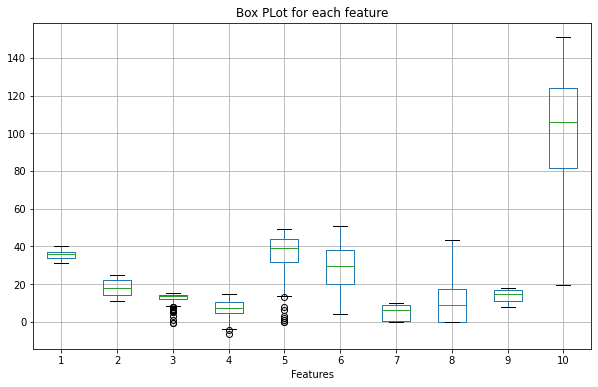

In [79]:
X=np.array(data.iloc[:,1:])
y=np.array(data.iloc[:,0])
## Plotting box plot for each variable to understand their distribution
plt.figure(figsize=(10,6))
data.iloc[:,1:].boxplot(column=list(data.iloc[:,1:].columns))
plt.xlabel("Features")
plt.title("Box PLot for each feature")


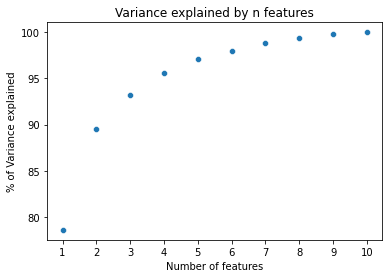

In [80]:
from sklearn.decomposition import PCA
# determing variance explained by n feature taken at a time
pca = PCA()
varr = []
for n in range(1,11):
    pca = PCA(n_components=n)
    X_train = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_
    varr.append(100*(explained_variance).sum())

## ploting the results
sns.scatterplot(x = range(1,11), y = varr)
plt.title("Variance explained by n features")
plt.xlabel('Number of features')
plt.ylabel("% of Variance explained")
plt.xticks(range(1,11))
plt.show()

- could be useful to just take only 3-4 features to make model simple

# Which Classification Model?
- Bayes
    - Naive
    - Bayesian Network
- Decision Trees
- Lazy Learners
    - KNN
    - CBR
- SVM: imbalance affects
- ANN: imbalance affects
### 
- Other concepts like cv-fold. How to specifically use it here?
- which measure to choose for 6-class classification?

## decision trees

In [81]:
# create a classifier object 
classifier = DecisionTreeClassifier(criterion='entropy',splitter='best',random_state=0,max_depth=5) 

X=np.array(data.iloc[:,1:])
y=np.array(data.iloc[:,0])

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
'''
although gives basic idea about accuracy 
but they are not correct
since we have class imbalance
Stratified CV has to be done to get representative samples for testing and training
'''
print(cross_val_score(classifier,x_scaled,y,cv=10))
print('avg score with 5 fold cv',(cross_val_score(classifier,x_scaled,y,cv=5)).mean(),' and sd is',(cross_val_score(classifier,x_scaled,y,cv=5)).std())

print('avg score with 10 fold cv',(cross_val_score(classifier,x_scaled,y,cv=10)).mean(),' and sd is',(cross_val_score(classifier,x_scaled,y,cv=10)).std())

clf=classifier.fit(x_scaled, y) 

[0.78571429 0.70731707 0.73170732 0.7804878  0.7804878  0.70731707
 0.80487805 0.6097561  0.80487805 0.80487805]
avg score with 5 fold cv 0.7373787834263885  and sd is 0.05109491339757037
avg score with 10 fold cv 0.7517421602787456  and sd is 0.05982107579403053


In [82]:
clf.score(X,y)
# on test set itself

0.014598540145985401

In [83]:
y_pred=clf.predict(X)

### visualize tree

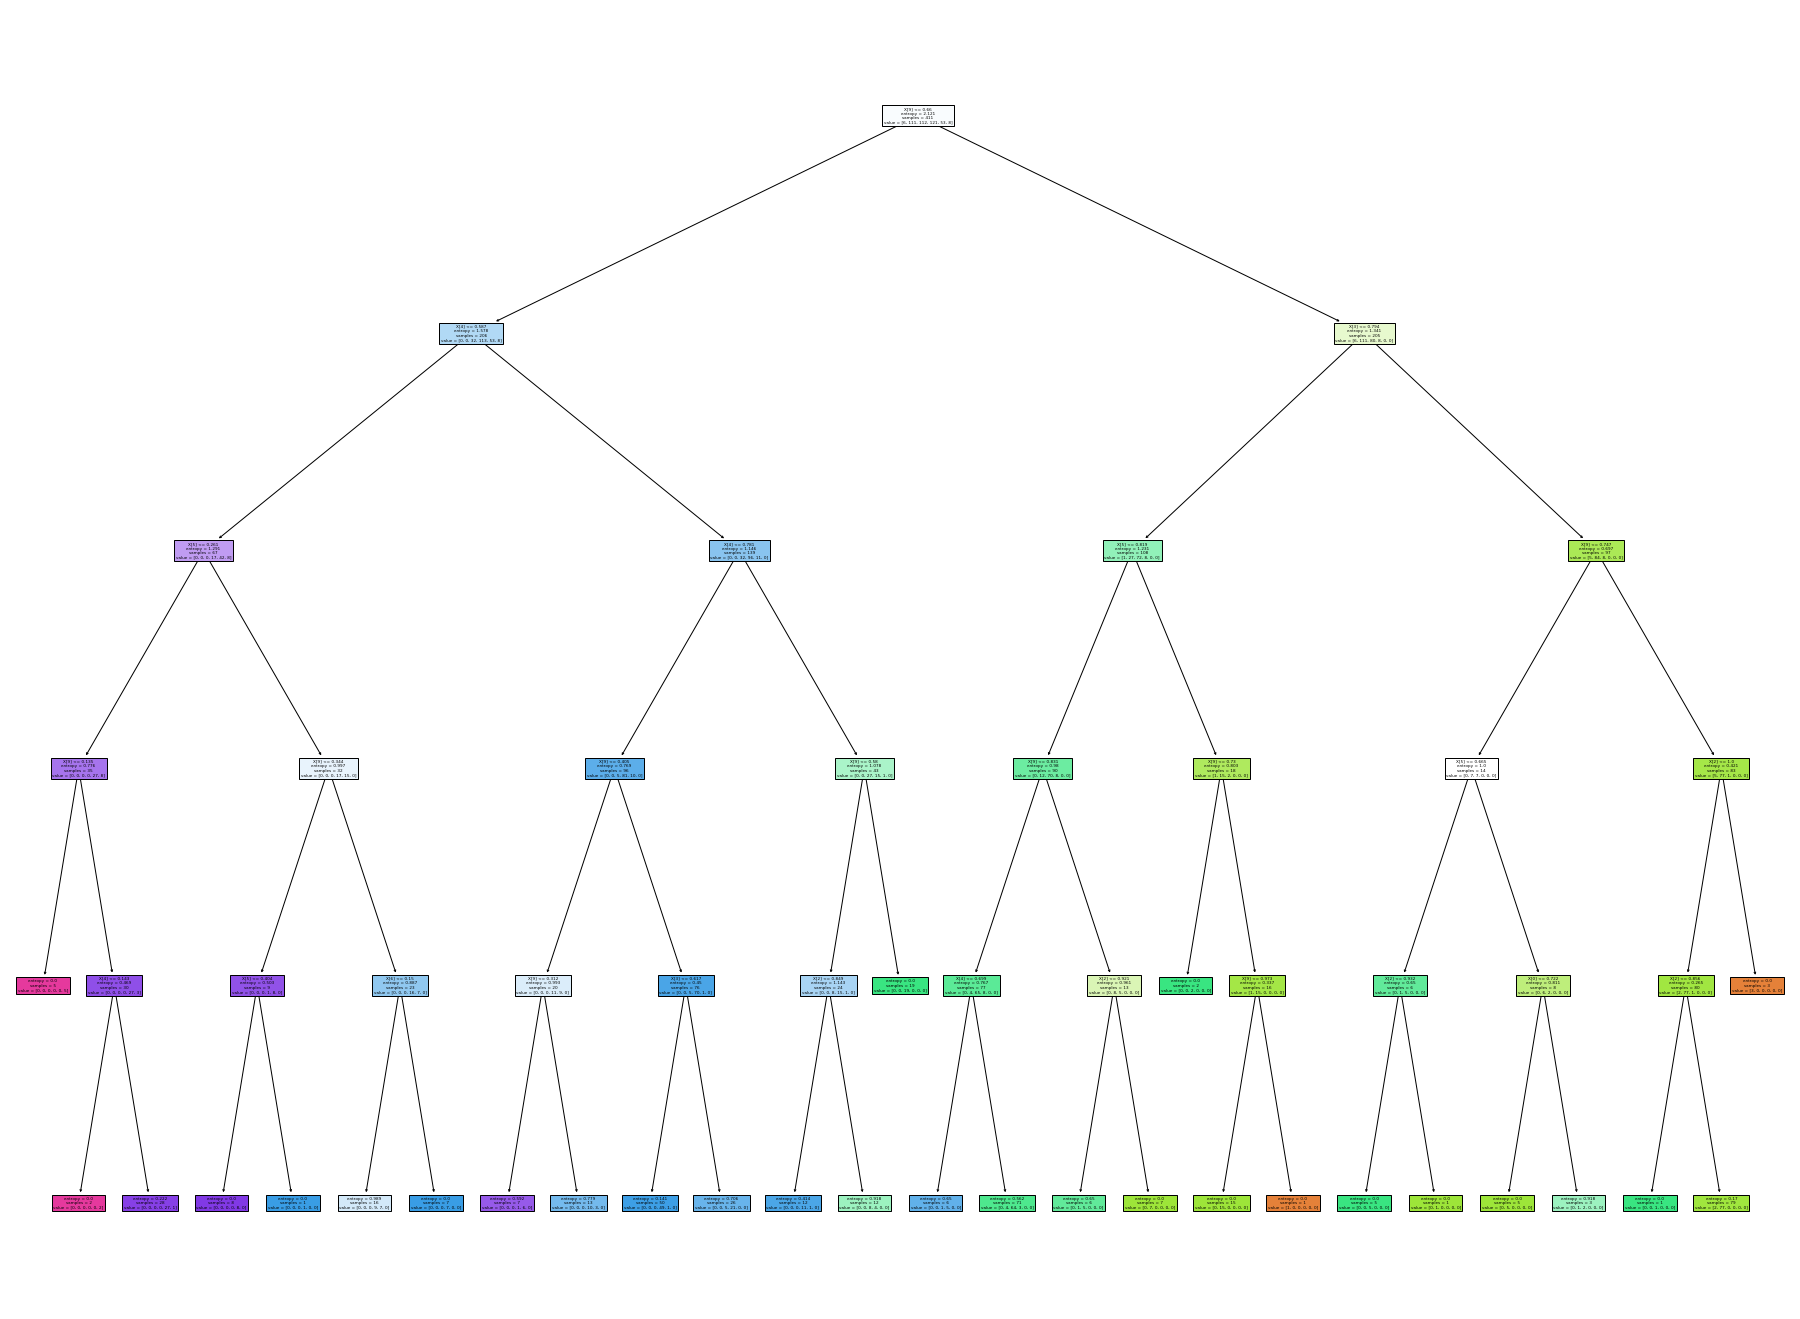

In [84]:
# plotting the tree
plt.figure(figsize=(32,24))
plot_tree(clf, filled=True)
plt.savefig('tree.png',dpi=300)
plt.show()

## Stratified CV to Deal with Class Imbalance
- On Decision Tree Classifier
- And on Logistics Regression

- gives around same result as decision tree in terms of accuracy. but overall in terms of accuracy decision tree is still better.

In [85]:
def get_cv_score(model_name=LogisticRegression,cv=10):

	global X,y
	
	# Feature Scaling for input features.
	scaler = preprocessing.MinMaxScaler()
	x_scaled = scaler.fit_transform(X)

	# Create classifier object.
	if model_name==LogisticRegression:
		# weights={}
		# for i,w in enumerate(X.shape[0] / (data.iloc[:,0].nunique() * data.iloc[:,0].value_counts().values)):
		# 	weights.get(i,w)
		# print(weights)
		model = model_name(class_weight=None,solver='lbfgs')
	elif model_name==DecisionTreeClassifier:
		model=model_name(random_state=1,criterion='gini',class_weight='balanced',max_depth=5)
	# Create StratifiedKFold object.
	skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
	# for repeated can try out
	# skf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=3, random_state=1)
	lst_accu_stratified = []

	for train_index, test_index in skf.split(X, y):
		x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
		y_train_fold, y_test_fold = y[train_index], y[test_index]
		model.fit(x_train_fold, y_train_fold)
		lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))

	# Print the output.
	print('\nMaximum Accuracy:',
		max(lst_accu_stratified)*100, '%')
	print('\nMinimum Accuracy:',
		min(lst_accu_stratified)*100, '%')
	print('\nOverall Accuracy:',
		mean(lst_accu_stratified)*100, '%')
	print('\nStandard Deviation is:', stdev(lst_accu_stratified))

In [86]:
print('Logistics Regression'.center(50,'+'))
get_cv_score(LogisticRegression)
print('Decision Tree'.center(50,'+'))
get_cv_score(DecisionTreeClassifier)

+++++++++++++++Logistics Regression+++++++++++++++

Maximum Accuracy: 87.8048780487805 %

Minimum Accuracy: 65.85365853658537 %

Overall Accuracy: 76.13821138211382 %

Standard Deviation is: 0.062214160077487375
++++++++++++++++++Decision Tree+++++++++++++++++++

Maximum Accuracy: 80.48780487804879 %

Minimum Accuracy: 70.73170731707317 %

Overall Accuracy: 75.66202090592334 %

Standard Deviation is: 0.032994408176673276


# I choose Decision Tree Classifier. And with optimized parameters from CV; I train the model on whole training dataset and predict values. It has been done in `classifier-s110.py` file.